In [1]:
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import helper_functions as hf
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
train = pd.read_csv('application_train.csv').set_index('SK_ID_CURR')
test = pd.read_csv('application_test.csv').set_index('SK_ID_CURR')
labels = train['TARGET']
X_train = train.drop('TARGET', axis = 1)
X=pd.concat([X_train,test],axis=0)

In [3]:
app = pd.read_csv('app.csv').set_index('SK_ID_CURR')
bur = pd.read_csv('bur.csv').set_index('SK_ID_CURR').loc[X.index]
prev = pd.read_csv('prev_curr.csv').set_index('SK_ID_CURR').loc[X.index]
ins = pd.read_csv('ins_curr.csv').set_index('SK_ID_CURR').loc[X.index]
cc = pd.read_csv('cc_curr.csv').set_index('SK_ID_CURR').loc[X.index]
app.shape,bur.shape,prev.shape,ins.shape,cc.shape

((356255, 98), (356255, 288), (356255, 543), (356255, 327), (356255, 124))

In [4]:
feats = pd.concat([app,bur,prev,ins,cc],axis=1)
print(feats.shape)
feats = hf.drop_high_corrs(feats,0.95)

(356255, 1380)
Removing 128 columns ['prev_RATE_INTEREST_PRIMARY_max', 'prev_RATE_INTEREST_PRIMARY_mean', 'prev_RATE_INTEREST_PRIVILEGED_max', 'prev_RATE_INTEREST_PRIVILEGED_mean', 'prev_SELLERPLACE_AREA_mean', 'prev_SELLERPLACE_AREA_sum', 'prev_DAYS_FIRST_DRAWING_max', 'prev_DAYS_FIRST_DRAWING_mean', 'prev_DAYS_FIRST_DRAWING_sum', 'prev_prev_f2_max', 'prev_prev_f2_mean', 'prev_prev_f2_sum', 'prev_prev_f3_sum', 'prev_prev_f4_max', 'prev_prev_f4_mean', 'prev_prev_f4_sum', 'prev_SK_DPD_weighted_sum', 'prev_SK_DPD_DEF_weighted_sum', 'prev_NAME_CONTRACT_STATUS_Approved_weighted_sum', 'prev_NAME_CONTRACT_STATUS_Completed_weighted_min', 'prev_NAME_CONTRACT_STATUS_Demand_weighted_sum', 'prev_NAME_CONTRACT_STATUS_OTHER_weighted_sum', 'prev_NAME_CONTRACT_STATUS_Returned to the store_weighted_sum', 'prev_NAME_CONTRACT_STATUS_Signed_weighted_sum', 'prev_CNT_INSTALMENT_var_sum', 'prev_SK_DPD_max_sum', 'prev_SK_DPD_var_sum', 'prev_SK_DPD_DEF_sum_mean', 'prev_SK_DPD_DEF_sum_sum', 'prev_NAME_CONTRACT

In [5]:
feats.to_csv('X_all.csv',columns=feats.columns)
feats = pd.read_csv('X_all.csv').set_index('SK_ID_CURR')
feats

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,...,cc_AMT_DRAWINGS_ATM_CURRENT_weighted_min,cc_AMT_DRAWINGS_OTHER_CURRENT_weighted_min,cc_NAME_CONTRACT_STATUS_weighted_min,cc_cc_f1_weighted_min,cc_cc_f2_weighted_min,cc_cc_f3_weighted_min,cc_cc_f5_weighted_min,cc_cc_f7_weighted_min,cc_cc_f8_weighted_min,cc_cc_f9_weighted_min
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0,1,0,1,1,1,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,1,0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0,1,0,0,0,0,0,2,0,0,...,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
100007,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100008,0,0,0,0,2,1,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100009,0,1,1,0,0,2,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100010,0,0,1,0,0,1,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,0,1,0,0,3,3,0,1,0,0,...,495.320550,0.0,1.000000,3.724845,0.002621,0.345484,NaN,0.002752,0.0,0.000000


In [6]:
def make_int(x):
    try:
        return int(x)
    except:
        return -1
    
feats[feats.columns[:50]] = feats[feats.columns[:50]].applymap(make_int)
f_train = feats.loc[train.index]
f_test = feats.loc[test.index]
print(f_train.shape, f_test.shape)

(307511, 1252) (48744, 1252)


In [7]:
feats.columns[:50]

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_D

In [8]:
X_train, X_test, y_train, y_test = train_test_split(f_train, labels, test_size=0.15, random_state=8)

In [9]:
def parameter_opt(X, y, init_round=10, opt_round=20, n_folds=5, random_seed=7, n_estimators=10000, learning_rate=0.05, output_process=False):

    train_data = lgb.Dataset(data=X, label=y, categorical_feature = list(range(50)), free_raw_data=False)

    def lgb_(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2,
                 min_split_gain, min_child_weight,min_data_in_leaf, scale_pos_weight,bagging_freq):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate,
                  'early_stopping_round':200, 'metric':'auc','device':'gpu'}
        
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['scale_pos_weight'] = scale_pos_weight
        params['bagging_freq'] = int(round(bagging_freq))
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=False, verbose_eval=50, metrics=['auc'])
        return max(cv_result['auc-mean'])
    
    bayes_opt = BayesianOptimization(lgb_, {'num_leaves': (6, 63),
                                            'feature_fraction': (0.4, 0.95),
                                            'bagging_fraction': (0.6, 0.95),
                                            'max_depth': (8, 15.99),
                                            'lambda_l1': (0, 1),
                                            'lambda_l2': (0, 1),
                                            'min_split_gain': (0.005, 0.1),
                                            'min_child_weight': (10, 50),
                                            'min_data_in_leaf': (1000,8000),
                                            'scale_pos_weight': (5,12),
                                            'bagging_freq': (2,5)},random_state=0)
    
    bayes_opt.maximize(init_points=init_round, n_iter=opt_round)
    if output_process == True: 
        bayes_opt.points_to_csv("bayes_opt.csv")
    return bayes_opt.res['max']['max_params']

opt_params = parameter_opt(X_train, y_train, init_round=10, opt_round=15, n_folds=5, random_seed=7, n_estimators=250000, learning_rate=0.02)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_data_in_leaf |   min_split_gain |   num_leaves |   scale_pos_weight | 
[50]	cv_agg's auc: 0.758409 + 0.00375267
[100]	cv_agg's auc: 0.768794 + 0.00353691
[150]	cv_agg's auc: 0.775099 + 0.00343025
[200]	cv_agg's auc: 0.778722 + 0.00341139
[250]	cv_agg's auc: 0.781327 + 0.003413
[300]	cv_agg's auc: 0.783238 + 0.00329199
[350]	cv_agg's auc: 0.784712 + 0.00317639
[400]	cv_agg's auc: 0.78559 + 0.00318079
[450]	cv_agg's auc: 0.786367 + 0.00318876
[500]	cv_agg's auc: 0.786959 + 0.00318045
[550]	cv_agg's auc: 0.78748 + 0.00310004
[600]	cv_agg's auc: 0.787898 + 0.00306732
[650]	cv_agg's auc: 0.788251 

[550]	cv_agg's auc: 0.788303 + 0.00305654
[600]	cv_agg's auc: 0.788682 + 0.00303591
[650]	cv_agg's auc: 0.788909 + 0.00299003
[700]	cv_agg's auc: 0.789273 + 0.00291745
[750]	cv_agg's auc: 0.789466 + 0.00285369
[800]	cv_agg's auc: 0.789581 + 0.00276398
[850]	cv_agg's auc: 0.789666 + 0.00272475
[900]	cv_agg's auc: 0.789645 + 0.00266563
[950]	cv_agg's auc: 0.789715 + 0.00258895
[1000]	cv_agg's auc: 0.789714 + 0.00262743
[1050]	cv_agg's auc: 0.789773 + 0.00262959
[1100]	cv_agg's auc: 0.789831 + 0.00262684
[1150]	cv_agg's auc: 0.789737 + 0.00266842
[1200]	cv_agg's auc: 0.789706 + 0.00264298
[1250]	cv_agg's auc: 0.789686 + 0.00257894
    6 | 09m55s |    0.78985 |             0.8240 |         3.7285 |             0.4479 |      0.6706 |      0.1613 |     12.9349 |            11.5675 |          2857.7264 |           0.0400 |      42.8160 |             6.2823 | 
[50]	cv_agg's auc: 0.759353 + 0.00431588
[100]	cv_agg's auc: 0.766348 + 0.00406948
[150]	cv_agg's auc: 0.77185 + 0.00380347
[200]	cv_ag

[850]	cv_agg's auc: 0.786383 + 0.00343076
[900]	cv_agg's auc: 0.786611 + 0.00339126
[950]	cv_agg's auc: 0.786914 + 0.00332925
[1000]	cv_agg's auc: 0.787084 + 0.00338793
[1050]	cv_agg's auc: 0.787309 + 0.00336077
[1100]	cv_agg's auc: 0.787457 + 0.00335652
[1150]	cv_agg's auc: 0.787589 + 0.00337542
[1200]	cv_agg's auc: 0.787722 + 0.0033702
[1250]	cv_agg's auc: 0.787888 + 0.00338452
[1300]	cv_agg's auc: 0.788027 + 0.0033154
[1350]	cv_agg's auc: 0.788151 + 0.00334069
[1400]	cv_agg's auc: 0.788258 + 0.00333665
[1450]	cv_agg's auc: 0.788325 + 0.00334977
[1500]	cv_agg's auc: 0.788359 + 0.00339086
[1550]	cv_agg's auc: 0.788418 + 0.00338405
[1600]	cv_agg's auc: 0.788482 + 0.00341748
[1650]	cv_agg's auc: 0.788572 + 0.0034486
[1700]	cv_agg's auc: 0.78856 + 0.00346287
[1750]	cv_agg's auc: 0.788599 + 0.00350112
[1800]	cv_agg's auc: 0.788676 + 0.00350987
[1850]	cv_agg's auc: 0.788683 + 0.00350823
[1900]	cv_agg's auc: 0.788732 + 0.00344597
[1950]	cv_agg's auc: 0.788749 + 0.00337952
[2000]	cv_agg's au

[1600]	cv_agg's auc: 0.786844 + 0.00295614
[1650]	cv_agg's auc: 0.786948 + 0.00291629
[1700]	cv_agg's auc: 0.787067 + 0.00286292
[1750]	cv_agg's auc: 0.787121 + 0.00281969
[1800]	cv_agg's auc: 0.787187 + 0.00282486
[1850]	cv_agg's auc: 0.78731 + 0.00278684
[1900]	cv_agg's auc: 0.787374 + 0.00278747
[1950]	cv_agg's auc: 0.787461 + 0.00274531
[2000]	cv_agg's auc: 0.787509 + 0.00276764
[2050]	cv_agg's auc: 0.787533 + 0.00278073
[2100]	cv_agg's auc: 0.787589 + 0.00278231
[2150]	cv_agg's auc: 0.78765 + 0.00277872
[2200]	cv_agg's auc: 0.787724 + 0.00274568
[2250]	cv_agg's auc: 0.787779 + 0.00273995
[2300]	cv_agg's auc: 0.787833 + 0.00269579
[2350]	cv_agg's auc: 0.787856 + 0.00263206
[2400]	cv_agg's auc: 0.787933 + 0.00263994
[2450]	cv_agg's auc: 0.78794 + 0.00262536
[2500]	cv_agg's auc: 0.787935 + 0.00258185
[2550]	cv_agg's auc: 0.787946 + 0.00256571
[2600]	cv_agg's auc: 0.787996 + 0.00259313
[2650]	cv_agg's auc: 0.788015 + 0.00254793
[2700]	cv_agg's auc: 0.788026 + 0.00255558
[2750]	cv_agg'

[3200]	cv_agg's auc: 0.787691 + 0.00242072
[3250]	cv_agg's auc: 0.787706 + 0.00238373
   18 | 12m20s |    0.78774 |             0.6371 |         4.6913 |             0.5409 |      0.7292 |      0.9484 |     15.6360 |            47.7610 |          7221.2291 |           0.0178 |       7.0899 |            10.2380 | 
[50]	cv_agg's auc: 0.755759 + 0.00384508
[100]	cv_agg's auc: 0.767097 + 0.00384748
[150]	cv_agg's auc: 0.773403 + 0.00363145
[200]	cv_agg's auc: 0.777194 + 0.0033813
[250]	cv_agg's auc: 0.779834 + 0.00324555
[300]	cv_agg's auc: 0.781933 + 0.00327329
[350]	cv_agg's auc: 0.783476 + 0.00325192
[400]	cv_agg's auc: 0.78468 + 0.00321853
[450]	cv_agg's auc: 0.785612 + 0.00319434
[500]	cv_agg's auc: 0.78636 + 0.00309954
[550]	cv_agg's auc: 0.78697 + 0.00309283
[600]	cv_agg's auc: 0.787408 + 0.00305956
[650]	cv_agg's auc: 0.787679 + 0.00305689
[700]	cv_agg's auc: 0.788037 + 0.00289898
[750]	cv_agg's auc: 0.788247 + 0.00290675
[800]	cv_agg's auc: 0.788459 + 0.00292941
[850]	cv_agg's auc

[600]	cv_agg's auc: 0.788929 + 0.00338353
[650]	cv_agg's auc: 0.789222 + 0.00335275
[700]	cv_agg's auc: 0.789503 + 0.00332705
[750]	cv_agg's auc: 0.789699 + 0.00334817
[800]	cv_agg's auc: 0.789784 + 0.00334297
[850]	cv_agg's auc: 0.789923 + 0.00329141
[900]	cv_agg's auc: 0.789971 + 0.00333913
[950]	cv_agg's auc: 0.790048 + 0.00329953
[1000]	cv_agg's auc: 0.790016 + 0.00327379
[1050]	cv_agg's auc: 0.789954 + 0.00322166
[1100]	cv_agg's auc: 0.789913 + 0.00317674
[1150]	cv_agg's auc: 0.789833 + 0.00317139
   24 | 12m52s |    0.79005 |             0.8503 |         2.2236 |             0.4866 |      0.1172 |      0.8894 |     13.1103 |            10.3910 |          2934.9218 |           0.0838 |      61.5910 |             5.7381 | 
[50]	cv_agg's auc: 0.75959 + 0.00382335
[100]	cv_agg's auc: 0.768506 + 0.00382127
[150]	cv_agg's auc: 0.775056 + 0.00350774
[200]	cv_agg's auc: 0.779173 + 0.00335844
[250]	cv_agg's auc: 0.781811 + 0.00343387
[300]	cv_agg's auc: 0.783641 + 0.00350126
[350]	cv_agg'

In [11]:
opt_params

{'num_leaves': 61.59095320761656,
 'feature_fraction': 0.48661969486659096,
 'bagging_fraction': 0.8503364504260739,
 'max_depth': 13.110348347230918,
 'lambda_l1': 0.11722803196057063,
 'lambda_l2': 0.8893748763177247,
 'min_split_gain': 0.0837960708150188,
 'min_child_weight': 10.39103579011432,
 'min_data_in_leaf': 2934.921783660563,
 'scale_pos_weight': 5.7380535943036595,
 'bagging_freq': 2.223648013692337}

In [65]:
lgbm_train = lgb.Dataset(data = X_train, label = y_train, categorical_feature = list(range(50)), free_raw_data=False)
lgbm_valid = lgb.Dataset(data = X_test, label = y_test, categorical_feature = list(range(50)), free_raw_data=False)

model_params = {
     'num_leaves': 61,
     'learning_rate':0.005,
     'feature_fraction': 0.48661969486659096,
     'bagging_fraction': 0.8503364504260739,
     'max_depth': 13,
     'lambda_l1': 0.11722803196057063,
     'lambda_l2': 0.8893748763177247,
     'min_split_gain': 0.0837960708150188,
     'min_child_weight': 10.39103579011432,
     'min_data_in_leaf': 2934,
     'scale_pos_weight': 5.7380535943036595,
     'bagging_freq': 2,
     'max_bin':15,
     'device':'gpu',
     'metrics':'auc'
}

clf = lgb.train(train_set = lgbm_train,valid_sets = lgbm_valid,params = model_params,
                verbose_eval = 500,num_boost_round = 100000,
                early_stopping_rounds = 500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.762319
[1000]	valid_0's auc: 0.771383
[1500]	valid_0's auc: 0.776043
[2000]	valid_0's auc: 0.778553
[2500]	valid_0's auc: 0.780137
[3000]	valid_0's auc: 0.781085
[3500]	valid_0's auc: 0.781701
[4000]	valid_0's auc: 0.78225
[4500]	valid_0's auc: 0.782525
[5000]	valid_0's auc: 0.78257
[5500]	valid_0's auc: 0.782525
Early stopping, best iteration is:
[5030]	valid_0's auc: 0.782599


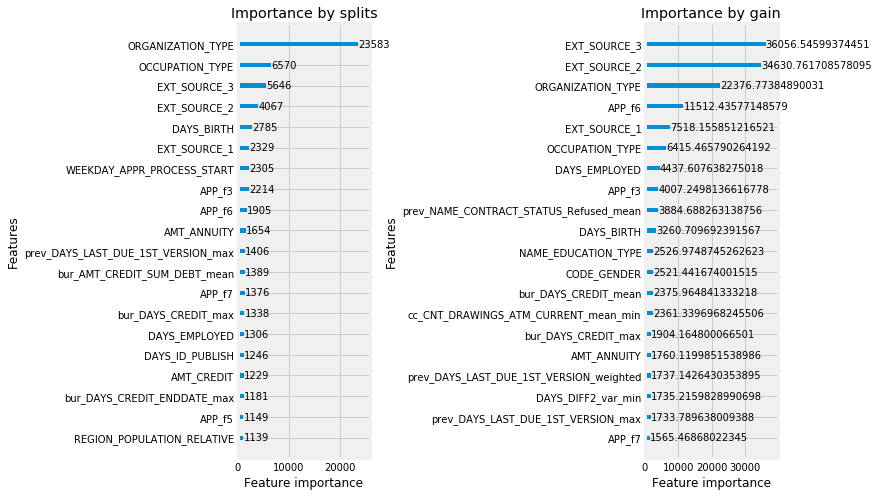

In [68]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[11, 7]) 
lgb.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split') 
lgb.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain') 
ax.set_title('Importance by splits') 
ax1.set_title('Importance by gain') 
plt.tight_layout() 
plt.show() 

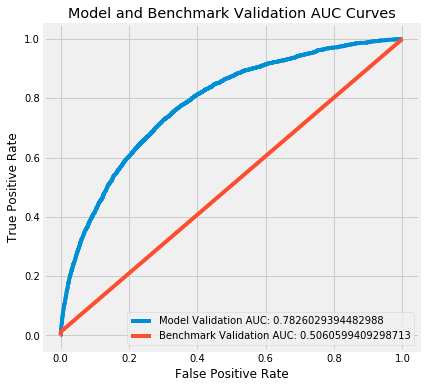

In [74]:
from sklearn.metrics import roc_curve

train = pd.read_csv('application_train.csv').set_index('SK_ID_CURR')
labels_b = train['TARGET']
train.drop('TARGET', axis = 1, inplace=True)
for i in train.select_dtypes(exclude=[int,float,bool]):
    train[i] = pd.factorize(train[i])[0]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(train, labels_b,
                                                    test_size=0.15, random_state=8)
benchmark = lgb.LGBMClassifier()
benchmark.fit(X_train_b, y_train_b)

y_pred_b = benchmark.predict(X_test_b)
fprb, tprb, _b = roc_curve(y_test_b,  y_pred_b)
benchmark_auc = roc_auc_score(y_test_b, y_pred_b)

y_pred = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
model_auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,label="Model Validation AUC: "+str(model_auc))
plt.plot(fprb,tprb,label="Benchmark Validation AUC: "+str(benchmark_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('Model and Benchmark Validation AUC Curves')
plt.show()

In [75]:
preds = pd.DataFrame(clf.predict(f_test),index=f_test.index,columns=['TARGET'])
preds.to_csv('submission.csv')
preds

,TARGET
SK_ID_CURR,
100001,0.036419
100005,0.199244
100013,0.054893
100028,0.021116
100038,0.131853
100042,0.082780
100057,-0.026705
100065,0.001937
100066,0.032127


In [76]:
clf.save_model('final_model.txt')